# TITLE

Concepts:

## CONCEPT

## CONCEPT


Author: Terence Lim

References:

- reference

In [1]:
%matplotlib inline
import dives
import time
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

from dives.util import fractiles, DataFrame
from dives.dbengines import SQL, Redis
from dives.structured import BusDates, Benchmarks, CRSP, PSTAT, IBES, Signals
from dives.evaluate import BackTest, run_backtest

import secret    # passwords etc                                                                             
sql = SQL(**secret.value('sql'))
rdb = Redis(**secret.value('redis'))
bd = BusDates(sql)
bench = Benchmarks(sql, bd)
backtest = BackTest(sql, bench, 'RF')
crsp = CRSP(sql, bd, rdb)
pstat = PSTAT(sql, bd)
ibes = IBES(sql, bd)
signals = Signals(sql)
outdir = secret.value('rps')['dir']
html = 'index.html'


dives/__init__ : import dives ... [SUCCESS]


### comment

In [ ]:
    tic = time.time()
    columns = ['absacc','acc', 'agr', 'bm', 'cashpr', 'cfp', 'chcsho', 'chinv', 'depr', 'dy', 'egr',
               'ep', 'gma', 'grcapx', 'grltnoa', 'hire', 'invest', 'lev', 'lgr' ,'pchdepr',
               'pchgm_pchsale', 'pchquick', 'pchsale_pchinvt', 'pchsale_pchrect', 'pchsale_pchxsga',
               'pchsaleinv', 'pctacc', 'quick', 'rd_sale', 'rd_mve', 'realestate',
               'salecash', 'salerec', 'saleinv', 'secured', 'sgr', 'sp', 'tang',
               'bm_ia', 'cfp_ia', 'chatoia' , 'chpmia', 'pchcapx_ia', 'chempia', 'mve_ia']
    numlag = 6       # number of months to lag data for rebalance                                            
    end = 20181231   # last data date                                                                        

    # retrieve all annual, keep [permno, datadate] key with non null price (prccq) if any                    
    fields = ['sic', 'fyear', 'ib', 'oancf', 'at', 'act', 'che', 'lct', 'dlc', 'dltt',
              'prcc_f', 'csho', 'invt', 'dp', 'ppent', 'dvt', 'ceq',
              'revt', 'cogs', 'rect', 'aco', 'intan', 'ao', 'ap', 'lco', 'lo', 'capx',
              'emp', 'ppegt', 'lt', 'sale', 'xsga', 'xrd', 'fatb', 'fatl', 'dm']
    dg = pstat.get_linked(table = 'annual',
                          date_field = 'datadate',
                          fields = fields,
                          where = ('datadate <= %d' % end)
                          ).sort_values(['permno', 'datadate', 'ib'])
    fund = dg.drop_duplicates(['permno','datadate'], keep='first').copy()
    fund.index = list(zip(fund['permno'], fund['datadate']))  # initialize dataframe with multi-index        
    fund['rebaldate'] = [bd.endmo(x[1], numlag) for x in fund.index]

    # precompute, and lag common metrics: mve_f avg_at sic2                                                  
    fund['sic2'] = fund['sic'] // 100
    fund.loc[fund['sic'].isnull(), 'sic2'] = 0
    fund['fyear'] = fund['datadate'] // 10000    # can delete this                                           
    fund['mve_f'] = fund['prcc_f'] * fund['csho']                      # precompute mve_f                    

    lag = fund.shift(1, fill_value=0)                                  # lag is shift(1)                     
    lag.loc[lag['permno'] != fund['permno'], fields] = np.nan          # require same permno on row          
    fund['avg_at'] = (fund['at'] + lag['at']) / 2                      # precompute avg_at                   

    lag2 = fund.shift(2, fill_value=0)                                 # lag2 is shift(2)                    
    lag2.loc[lag2['permno'] != fund['permno'], fields] = np.nan        # require same permno on roa          
    lag['avg_at'] = (lag['at'] + lag2['at']) / 2                       # lag of avg_at                       

    # compute: cashpr depr dy ep lev quick                                                                   
    fund['bm'] = fund['ceq'] / fund['mve_f']                           # bm = ceq / mve_f                    
    fund['cashpr'] = (fund['mve_f'] + fund['dltt'] - fund['at']) / fund['che'] # cashpr =                    
    fund['depr'] = fund['dp'] / fund['ppent']                          # depr = dp / ppent                   
    fund['dy'] = fund['dvt'] / fund['mve_f']                           # dy = dvt / mve_f                    
    fund['ep'] = fund['ib'] / fund['mve_f']                            # ep = ib / mve_f                     
    fund['lev'] = fund['lt'] / fund['mve_f']                           # lev = lt / mve_f                    
    fund['quick'] = (fund['act'] - fund['invt']) / fund['lct']         # quick = (act - invt) / lct          
    fund['rd_sale'] = fund['xrd'] / fund['sale']                       # rd_sale = xrd / sale                
    fund['rd_mve'] = fund['xrd'] / fund['mve_f']                       # rd_mve = xrd / mve_f                
    fund['realestate'] = (fund['fatb'] + fund['fatl']) / fund['ppegt'] # realestate = fatb+fatl / ppegt      
    h = fund['ppegt'].isnull()                                         #           OR fatb+fatl / ppent      
    fund.loc[h, 'realestate'] = ((fund.loc[h, 'fatb'] + fund.loc[h, 'fatl']) / fund.loc[h, 'ppent'])
    fund['salecash'] = fund['sale'] / fund['che']                      # salecash = sale / che               
    fund['salerec'] = fund['sale'] / fund['rect']                      # salerec = sale / rect               
    fund['saleinv'] = fund['sale'] / fund['invt']                      # saleinv = sale / invt               
    fund['secured'] = fund['dm'] / fund['dltt']                        # secured = dm / dltt                 
    fund['sp'] = fund['sale'] / fund['mve_f']                          # sp = sale / mve_f                   
    fund['tang'] = (fund['che'] + fund['rect']*0.715 +                 # tang ~ che,rect,invt,ppent/at       
                    fund['invt']*0.547 + fund['ppent'] *0.535) / fund['at']

    # compute changes: agr chcsho chinv egr gma egr grcapx grltnoa emp invest lgr                            
    fund['agr'] = (fund['at'] / lag['at'])                             # agr = chg at                        
    fund['chcsho'] = (fund['csho'] / lag['csho'])                      # chcsho = chg csho                   
    fund['chinv'] = ((fund['invt'] - lag['invt']) / fund['avg_at'])    # chinv =                             
    fund['egr'] = (fund['ceq'] / lag['ceq'])                           # egr = chg ceq                       
    fund['gma'] = ((fund['revt'] - fund['cogs']) / lag['at'])          # gma = revt-cogs/at                  
    fund['grcapx'] = (fund['capx'] / lag2['capx'])                     # grcapx = chg2 capx                  
    fund['grltnoa'] =  ((fund['rect'] + fund['invt'] + fund['ppent'] + # grltnoa = GrNOA - TACC =            
                         fund['aco'] + fund['intan'] + fund['ao'] -    #   (chg (rect+invt+ppent+            
                         fund['ap'] - fund['lco'] - fund['lo']) /      #        aco+intan+ao                 
                        (lag['rect'] + lag['invt'] + lag['ppent'] +    #        -ap-lco-lo) -                
                         lag['aco'] + lag['intan'] + lag['ao'] -       #   chg (rect+invt+aco-ap-lco)        
                         lag['ap'] - lag['lco'] - lag['lo']) -         #   - dp) / avg_at                    
                        ((fund['rect'] + fund['invt'] + fund['aco'] -
                          fund['ap'] - fund['lco']) -
                         (lag['rect'] + lag['invt'] + lag['aco'] -
                          lag['ap'] - lag['lco']))) / fund['avg_at']
    fund['hire'] = (fund['emp'] / lag['emp']) - 1                      # hire = chg emp                      
    fund.loc[fund['hire'].isnull(), 'hire'] = 0
    fund['invest'] = (((fund['ppegt'] - lag['ppegt']) +                # invest =                            
                       (fund['invt'] - lag['invt'])) / lag['at'])      #   chg ppegt + chg invt / at    
    h = fund['invest'].isnull()                                        # if missing ppegt then ppent         
    fund.loc[h,'invest'] = (((fund.loc[h,'ppent'] - lag.loc[h,'ppent']) +
                             (fund.loc[h,'invt'] - lag.loc[h,'invt'])) / lag.loc[h,'at'])
    fund['lgr'] = (fund['lt'] / lag['lt'])                             # lgr = chg lt                        
    fund['pchdepr'] = ((fund['dp'] / fund['ppent']) /
                       (lag['dp'] / lag['ppent']))                     # pchdepr = chg (dp/ppent)            
    fund['pchgm_pchsale'] = (((fund['sale'] - fund['cogs']) /          # pchgm_pchsale =                     
                              (lag['sale'] - lag['cogs'])) -           #   chg (sale-cogs) -                 
                             (fund['sale'] / lag['sale']))             #   chg sale                          
    fund['pchquick'] = (((fund['act'] - fund['invt']) / fund['lct']) / # pchquick =                          
                        ((lag['act'] - lag['invt']) / lag['lct']))     #   chg (act-invt/lct)                
    fund['pchsale_pchinvt'] = ((fund['sale'] / lag['sale']) -          # pchgm_pchinv =                      
                               (fund['invt'] / lag['invt']))           #   chg sale - chg invt               
    fund['pchsale_pchrect'] = ((fund['sale'] / lag['sale']) -          # pchgm_pchrect =                     
                               (fund['rect'] / lag['rect']))           #   chg sale - chg rect               
    fund['pchsale_pchxsga'] = ((fund['sale'] / lag['sale']) -          # pchgm_pchxsga =                     
                               (fund['xsga'] / lag['xsga']))           #   chg sale - chg xsga               
    fund['pchsaleinv'] = ((fund['sale'] / fund['invt']) /              # pchsaleinv =                        
                          (lag['sale'] / lag['invt']))                 #   chg (sale/inv)                    
    fund['sgr'] = (fund['sale'] / lag['sale'])                         # sgr = chg sale                      

    fund['chato'] = (fund['sale'] / fund['avg_at']) - (lag['sale'] / lag['avg_at'])
    fund['chpm'] = (fund['ib'] / fund['sale']) - (lag['ib'] / lag['sale'])
    fund['pchcapx'] = fund['capx'] / lag['capx']

    # compute signals with alternative definitions: acc absacc cfp                                           
    fund['_acc'] = (((fund['act'] - lag['act']) -             # _acc = (chg act - chg che)                   
                     (fund['che'] - lag['che'])) -            #       - (chg lct - chg dlc - dp)             
                    ((fund['lct'] - lag['lct']) -             #                                              
                     #((fund['txp'] - lag['txp']) -            # chg txp?                                    
                     (fund['dlc'] - lag['dlc']) - fund['dp']))
    fund['cfp'] = (fund['ib'] -
                   (((fund['act'] - lag['act']) -             # cfp = (chg act - chg che)                    
                     (fund['che'] - lag['che'])) -            #       - (chg lct - chg dlc -dp)              
                    ((fund['lct'] - lag['lct']) -             #     / (avg at)                               
                     #((fund['txp'] - lag['txp']) -            # chg txp?                                    
                     (fund['dlc'] - lag['dlc']) - fund['dp']))) / fund['mve_f']
    g = ~fund['oancf'].isnull()
    fund.loc[g, 'cfp'] = fund.loc[g, 'oancf'] / fund.loc[g, 'mve_f']
    fund.loc[g, '_acc'] = fund.loc[g, 'ib'] - fund.loc[g, 'oancf']
    fund['acc'] = fund['_acc'] / fund['avg_at']
    fund['absacc'] = abs(fund['_acc']) / fund['avg_at']
    fund['pctacc'] = fund['_acc'] / abs(fund['ib'])
    h = (fund['ib'] <= 0.01)
    fund.loc[h, 'pctacc'] = fund.loc[h, '_acc'] / 0.01

    # compute industry-adjusted: bm_ia cfp_ia chatoia chpmia pchcapx_ia chempia mve_ia                       
    cols = {'bm_ia':'bm', 'cfp_ia':'cfp', 'chatoia':'chato', 'chpmia':'chpm',
            'pchcapx_ia':'pchcapx', 'chempia':'hire', 'mve_ia':'mve_f'}
    group = fund.groupby(['sic2', 'fyear'])
    for k,v in cols.items():
        fund[k] = fund[v] - group[v].transform('mean')
    print('Elapsed: %.0f secs' % (time.time() - tic))

    for signal in columns:
        signals.save(fund, signal)

                            OLS Regression Results                            
Dep. Variable:           MINUS absacc   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     56.42
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.19e-23
Time:                        14:08:41   Log-Likelihood:                 2195.8
No. Observations:                 805   AIC:                            -4386.
Df Residuals:                     802   BIC:                            -4372.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      1.041      0.2

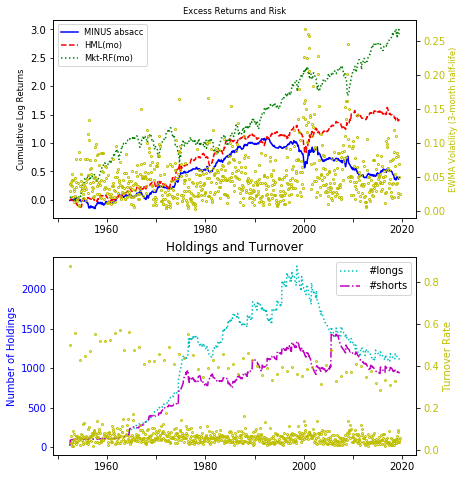

                            OLS Regression Results                            
Dep. Variable:              MINUS acc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.6085
Date:                Sat, 01 Feb 2020   Prob (F-statistic):              0.544
Time:                        14:10:18   Log-Likelihood:                 2174.9
No. Observations:                 805   AIC:                            -4344.
Df Residuals:                     802   BIC:                            -4330.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.001      4.707      0.0

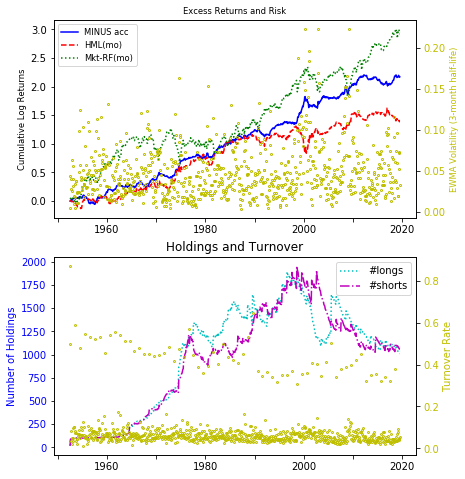

                            OLS Regression Results                            
Dep. Variable:              MINUS agr   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     105.1
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           2.77e-41
Time:                        14:12:00   Log-Likelihood:                 2225.4
No. Observations:                 806   AIC:                            -4445.
Df Residuals:                     803   BIC:                            -4431.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      2.894      0.0

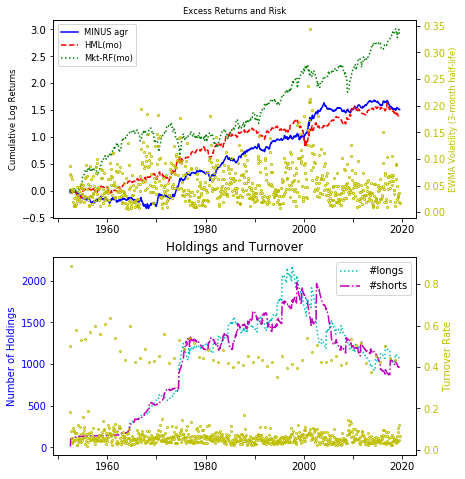

                            OLS Regression Results                            
Dep. Variable:                     bm   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     534.4
Date:                Sat, 01 Feb 2020   Prob (F-statistic):          1.28e-139
Time:                        14:13:38   Log-Likelihood:                 1762.9
No. Observations:                 675   AIC:                            -3520.
Df Residuals:                     672   BIC:                            -3506.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.001      1.553      0.1

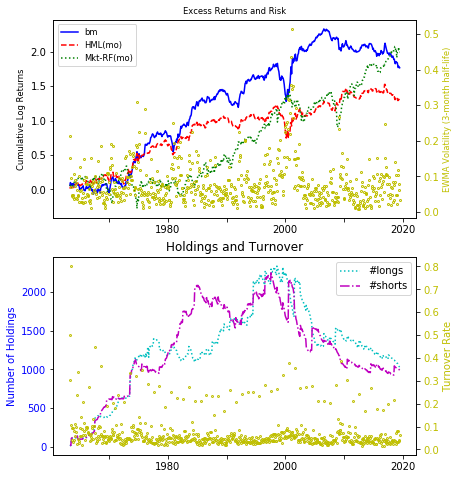

                            OLS Regression Results                            
Dep. Variable:           MINUS cashpr   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     290.8
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           6.45e-92
Time:                        14:15:10   Log-Likelihood:                 1752.2
No. Observations:                 681   AIC:                            -3498.
Df Residuals:                     678   BIC:                            -3485.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.410      0.6

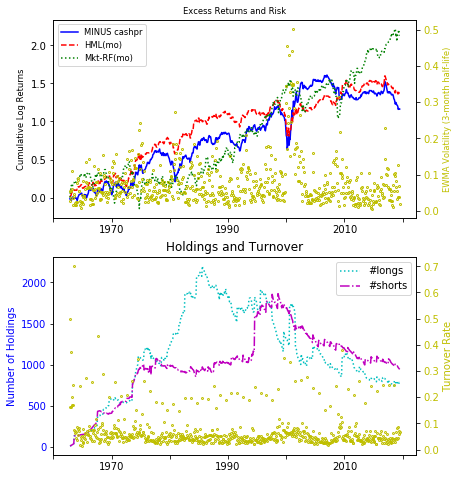

                            OLS Regression Results                            
Dep. Variable:                    cfp   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     22.65
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           3.01e-10
Time:                        14:16:45   Log-Likelihood:                 1569.3
No. Observations:                 678   AIC:                            -3133.
Df Residuals:                     675   BIC:                            -3119.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.001      2.242      0.0

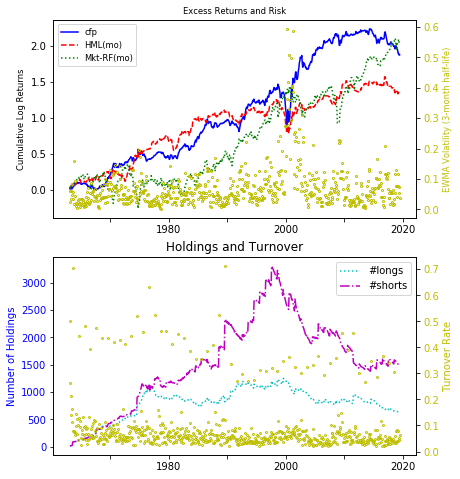

                            OLS Regression Results                            
Dep. Variable:           MINUS chcsho   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     86.23
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.20e-34
Time:                        14:18:23   Log-Likelihood:                 2148.6
No. Observations:                 806   AIC:                            -4291.
Df Residuals:                     803   BIC:                            -4277.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0033      0.001      5.192      0.0

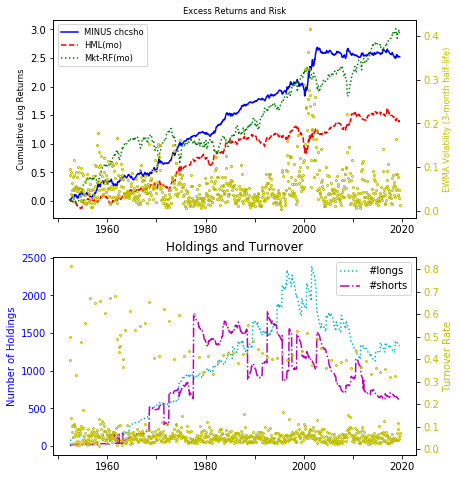

                            OLS Regression Results                            
Dep. Variable:            MINUS chinv   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     35.57
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.58e-15
Time:                        14:19:56   Log-Likelihood:                 2245.4
No. Observations:                 806   AIC:                            -4485.
Df Residuals:                     803   BIC:                            -4471.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0023      0.001      4.283      0.0

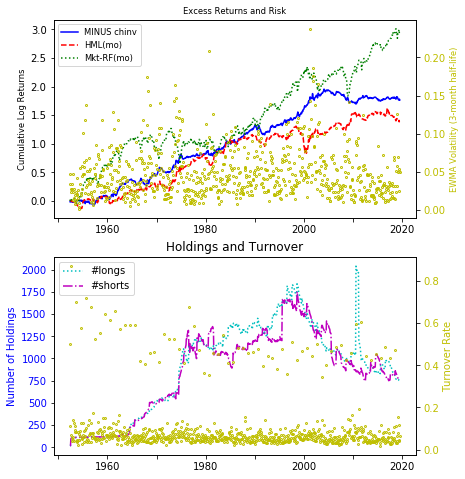

                            OLS Regression Results                            
Dep. Variable:                   depr   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     66.27
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           2.15e-27
Time:                        14:21:37   Log-Likelihood:                 1990.6
No. Observations:                 818   AIC:                            -3975.
Df Residuals:                     815   BIC:                            -3961.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0025      0.001      3.170      0.0

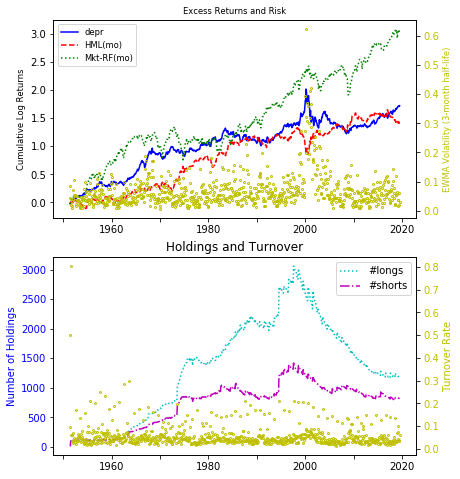

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     38.61
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.32e-16
Time:                        14:23:02   Log-Likelihood:                 1040.5
No. Observations:                 681   AIC:                            -2075.
Df Residuals:                     678   BIC:                            -2062.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.002      1.201      0.2

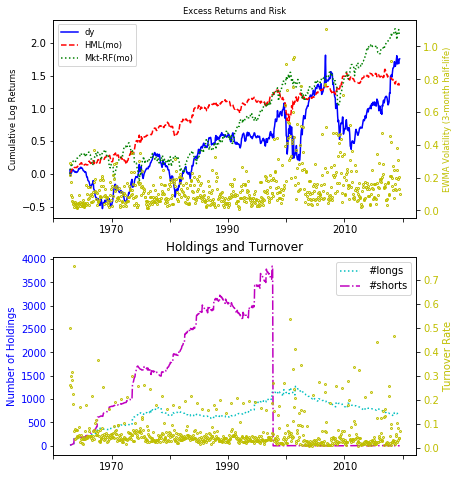

                            OLS Regression Results                            
Dep. Variable:              MINUS egr   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     67.59
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.84e-27
Time:                        14:24:32   Log-Likelihood:                 1780.7
No. Observations:                 672   AIC:                            -3555.
Df Residuals:                     669   BIC:                            -3542.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.001      1.407      0.1

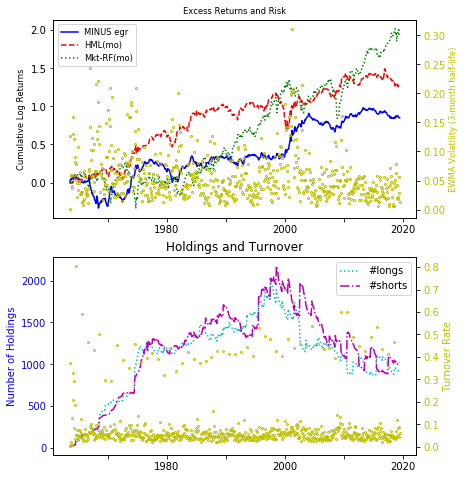

                            OLS Regression Results                            
Dep. Variable:                     ep   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     172.8
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           2.29e-61
Time:                        14:26:12   Log-Likelihood:                 1601.3
No. Observations:                 681   AIC:                            -3197.
Df Residuals:                     678   BIC:                            -3183.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.001      2.474      0.0

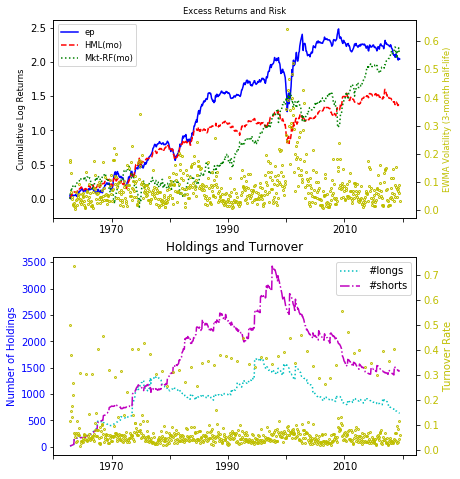

                            OLS Regression Results                            
Dep. Variable:                    gma   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     123.9
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.26e-47
Time:                        14:27:50   Log-Likelihood:                 2065.1
No. Observations:                 804   AIC:                            -4124.
Df Residuals:                     801   BIC:                            -4110.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0023      0.001      3.245      0.0

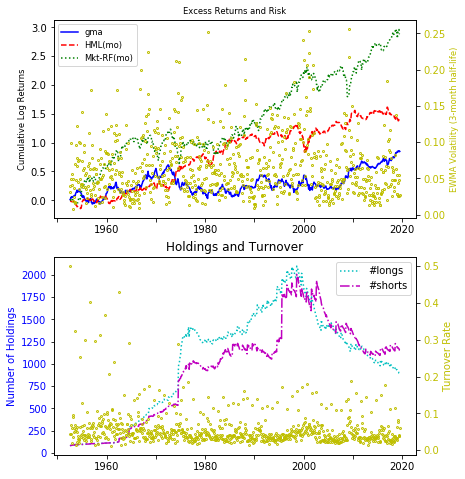

                            OLS Regression Results                            
Dep. Variable:           MINUS grcapx   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     16.80
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           7.13e-08
Time:                        14:29:20   Log-Likelihood:                 2224.2
No. Observations:                 793   AIC:                            -4442.
Df Residuals:                     790   BIC:                            -4428.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.001      3.321      0.0

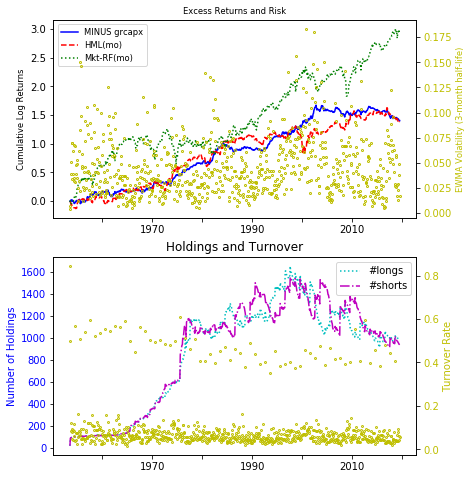

                            OLS Regression Results                            
Dep. Variable:                grltnoa   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.255
Date:                Sat, 01 Feb 2020   Prob (F-statistic):              0.106
Time:                        14:30:41   Log-Likelihood:                 1765.8
No. Observations:                 654   AIC:                            -3526.
Df Residuals:                     651   BIC:                            -3512.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0025      0.001      3.529      0.0

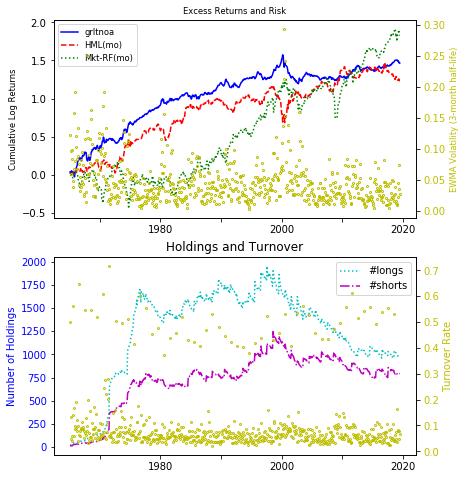

                            OLS Regression Results                            
Dep. Variable:             MINUS hire   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     150.2
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           2.95e-56
Time:                        14:32:22   Log-Likelihood:                 2252.0
No. Observations:                 818   AIC:                            -4498.
Df Residuals:                     815   BIC:                            -4484.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      1.545      0.1

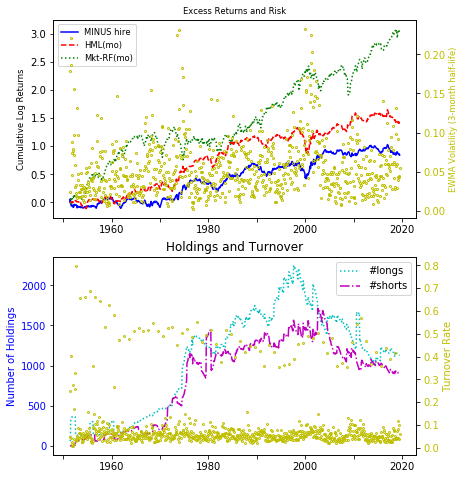

                            OLS Regression Results                            
Dep. Variable:           MINUS invest   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     83.43
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.20e-33
Time:                        14:33:57   Log-Likelihood:                 2197.5
No. Observations:                 806   AIC:                            -4389.
Df Residuals:                     803   BIC:                            -4375.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.001      4.124      0.0

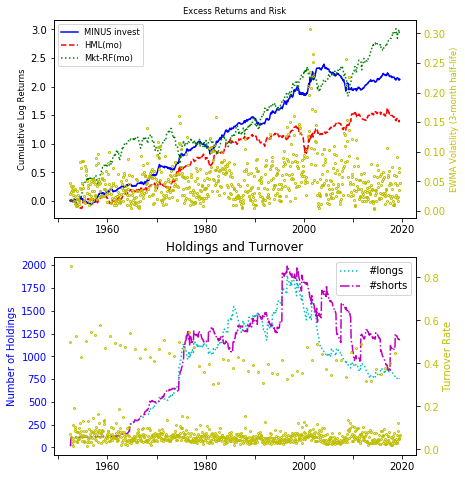

                            OLS Regression Results                            
Dep. Variable:                    lev   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     151.9
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           3.17e-55
Time:                        14:35:36   Log-Likelihood:                 1665.0
No. Observations:                 681   AIC:                            -3324.
Df Residuals:                     678   BIC:                            -3310.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0006      0.001     -0.686      0.4

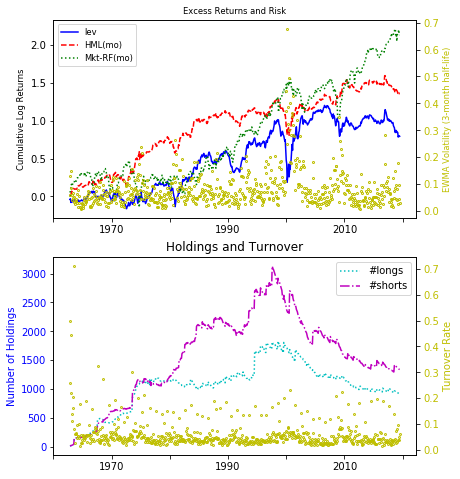

                            OLS Regression Results                            
Dep. Variable:              MINUS lgr   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     63.21
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           3.22e-26
Time:                        14:37:15   Log-Likelihood:                 2361.8
No. Observations:                 806   AIC:                            -4718.
Df Residuals:                     803   BIC:                            -4703.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.000      2.095      0.0

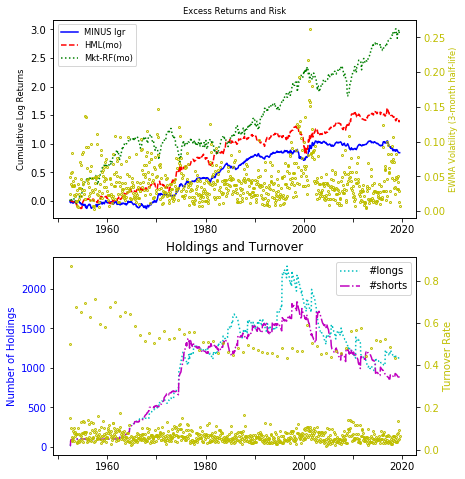

                            OLS Regression Results                            
Dep. Variable:                pchdepr   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     4.788
Date:                Sat, 01 Feb 2020   Prob (F-statistic):            0.00857
Time:                        14:38:54   Log-Likelihood:                 2466.9
No. Observations:                 806   AIC:                            -4928.
Df Residuals:                     803   BIC:                            -4914.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.000      2.572      0.0

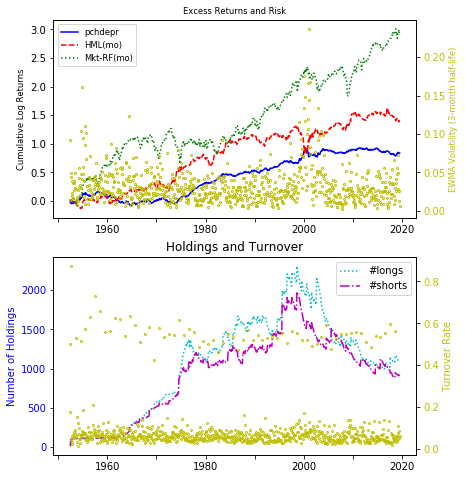

                            OLS Regression Results                            
Dep. Variable:          pchgm_pchsale   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     8.334
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           0.000262
Time:                        14:40:32   Log-Likelihood:                 2337.9
No. Observations:                 804   AIC:                            -4670.
Df Residuals:                     801   BIC:                            -4656.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.000      3.057      0.0

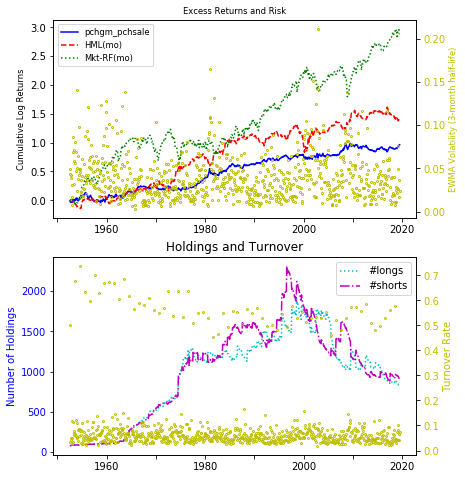

                            OLS Regression Results                            
Dep. Variable:               pchquick   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.187
Date:                Sat, 01 Feb 2020   Prob (F-statistic):              0.113
Time:                        14:42:03   Log-Likelihood:                 2487.7
No. Observations:                 806   AIC:                            -4969.
Df Residuals:                     803   BIC:                            -4955.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.000      2.294      0.0

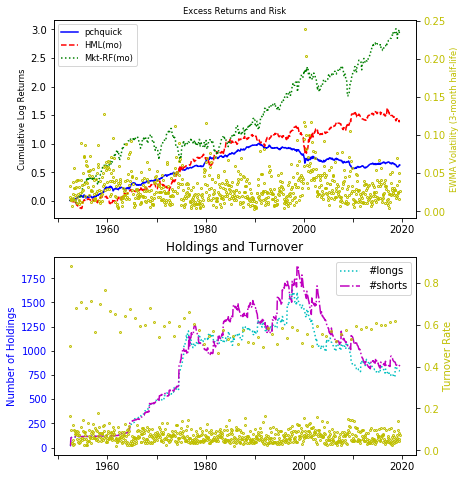

                            OLS Regression Results                            
Dep. Variable:        pchsale_pchinvt   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.7393
Date:                Sat, 01 Feb 2020   Prob (F-statistic):              0.478
Time:                        14:43:33   Log-Likelihood:                 2450.3
No. Observations:                 806   AIC:                            -4895.
Df Residuals:                     803   BIC:                            -4880.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.000      6.821      0.0

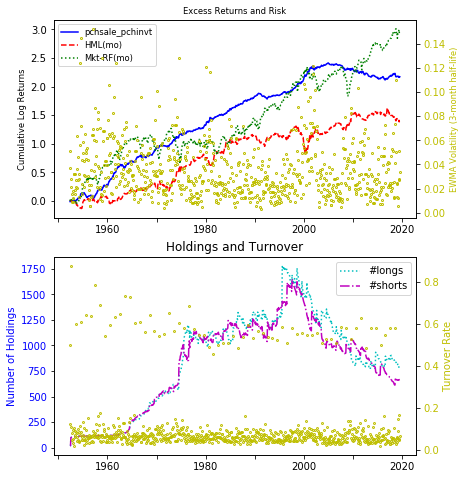

                            OLS Regression Results                            
Dep. Variable:        pchsale_pchrect   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.585
Date:                Sat, 01 Feb 2020   Prob (F-statistic):             0.0760
Time:                        14:45:11   Log-Likelihood:                 2484.9
No. Observations:                 806   AIC:                            -4964.
Df Residuals:                     803   BIC:                            -4950.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      1.709      0.0

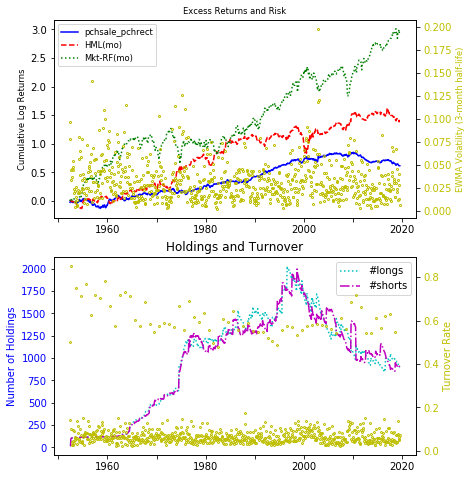

                            OLS Regression Results                            
Dep. Variable:        pchsale_pchxsga   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.307
Date:                Sat, 01 Feb 2020   Prob (F-statistic):              0.271
Time:                        14:46:42   Log-Likelihood:                 2248.7
No. Observations:                 804   AIC:                            -4491.
Df Residuals:                     801   BIC:                            -4477.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.774      0.4

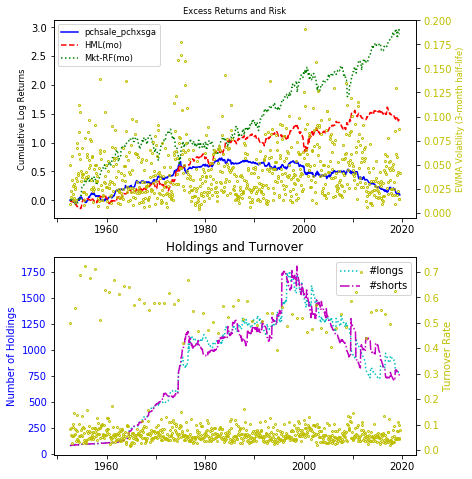

                            OLS Regression Results                            
Dep. Variable:             pchsaleinv   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                    0.9444
Date:                Sat, 01 Feb 2020   Prob (F-statistic):              0.389
Time:                        14:48:12   Log-Likelihood:                 2434.6
No. Observations:                 806   AIC:                            -4863.
Df Residuals:                     803   BIC:                            -4849.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.000      6.985      0.0

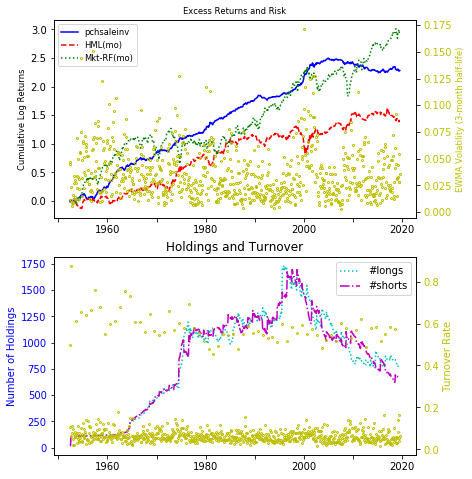

                            OLS Regression Results                            
Dep. Variable:           MINUS pctacc   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.536
Date:                Sat, 01 Feb 2020   Prob (F-statistic):             0.0798
Time:                        14:49:53   Log-Likelihood:                 2043.3
No. Observations:                 805   AIC:                            -4081.
Df Residuals:                     802   BIC:                            -4067.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.001      1.910      0.0

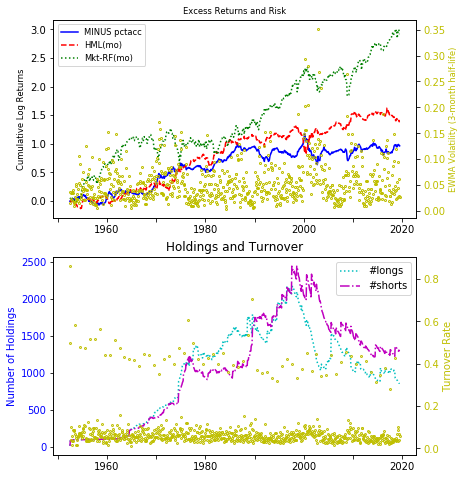

                            OLS Regression Results                            
Dep. Variable:                  quick   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     48.04
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.90e-20
Time:                        14:51:30   Log-Likelihood:                 1994.5
No. Observations:                 818   AIC:                            -3983.
Df Residuals:                     815   BIC:                            -3969.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.001      1.886      0.0

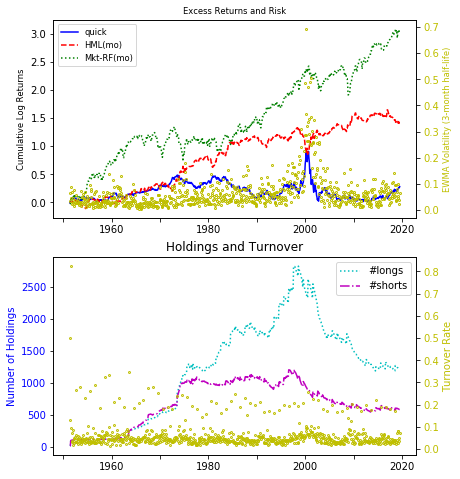

                            OLS Regression Results                            
Dep. Variable:                rd_sale   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     55.83
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           2.38e-23
Time:                        14:52:42   Log-Likelihood:                 1538.8
No. Observations:                 764   AIC:                            -3072.
Df Residuals:                     761   BIC:                            -3058.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.001      1.676      0.0

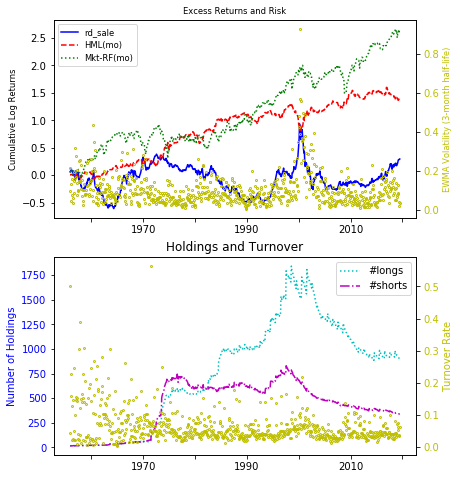

                            OLS Regression Results                            
Dep. Variable:                 rd_mve   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     11.51
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.22e-05
Time:                        14:53:50   Log-Likelihood:                 1372.0
No. Observations:                 672   AIC:                            -2738.
Df Residuals:                     669   BIC:                            -2725.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0048      0.001      3.469      0.0

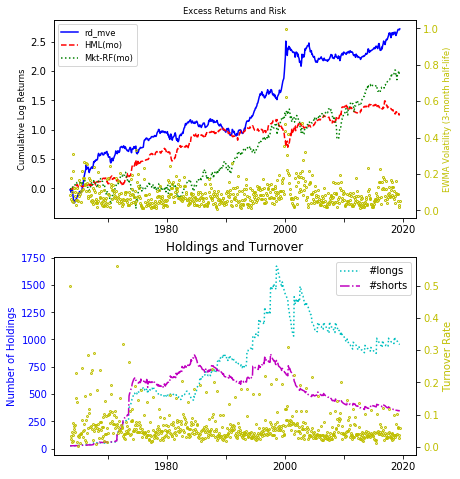

                            OLS Regression Results                            
Dep. Variable:             realestate   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     8.891
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           0.000166
Time:                        14:54:38   Log-Likelihood:                 1027.8
No. Observations:                 414   AIC:                            -2050.
Df Residuals:                     411   BIC:                            -2038.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0019      0.001      1.727      0.0

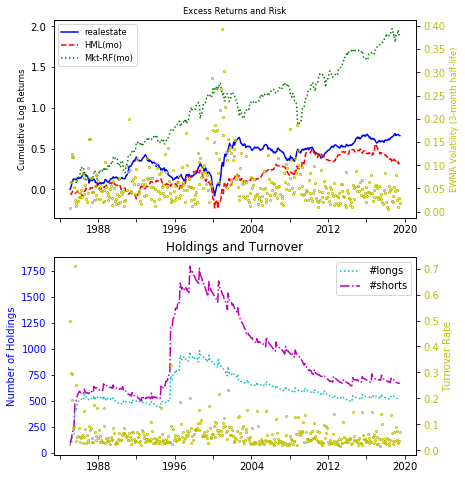

                            OLS Regression Results                            
Dep. Variable:         MINUS salecash   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     26.21
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           9.29e-12
Time:                        14:56:23   Log-Likelihood:                 2099.8
No. Observations:                 818   AIC:                            -4194.
Df Residuals:                     815   BIC:                            -4180.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      1.620      0.1

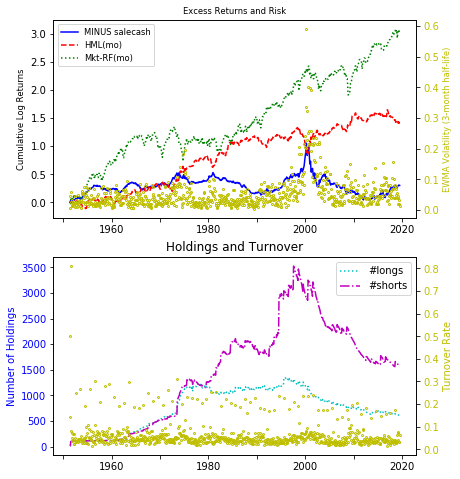

                            OLS Regression Results                            
Dep. Variable:                salerec   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     43.89
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           7.86e-19
Time:                        14:58:04   Log-Likelihood:                 2244.9
No. Observations:                 818   AIC:                            -4484.
Df Residuals:                     815   BIC:                            -4470.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      2.088      0.0

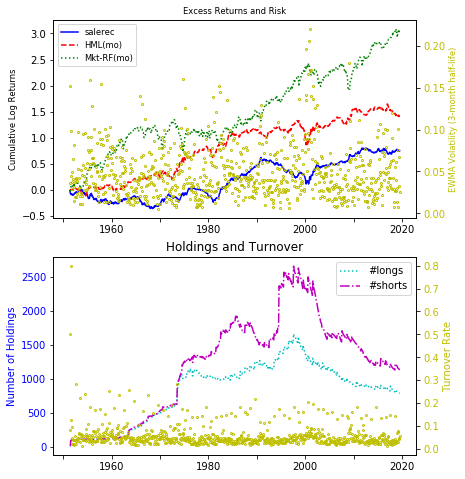

                            OLS Regression Results                            
Dep. Variable:                saleinv   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     67.22
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           9.53e-28
Time:                        14:59:35   Log-Likelihood:                 2228.2
No. Observations:                 818   AIC:                            -4450.
Df Residuals:                     815   BIC:                            -4436.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      3.618      0.0

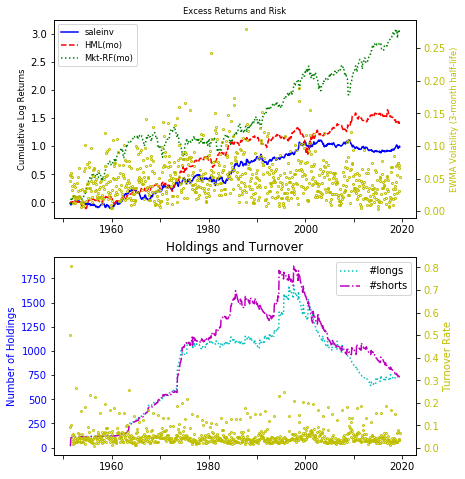

                            OLS Regression Results                            
Dep. Variable:                secured   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     69.62
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           4.78e-27
Time:                        15:00:32   Log-Likelihood:                 882.68
No. Observations:                 450   AIC:                            -1759.
Df Residuals:                     447   BIC:                            -1747.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0017      0.002     -0.938      0.3

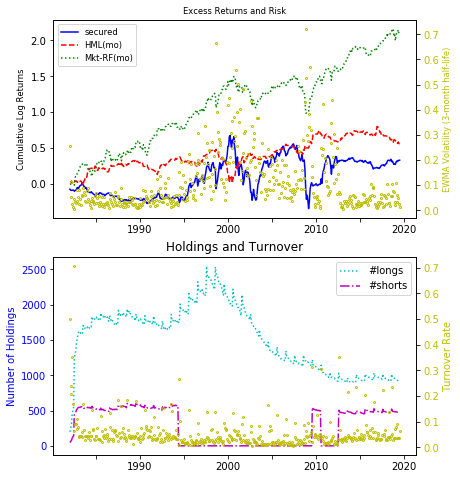

                            OLS Regression Results                            
Dep. Variable:              MINUS sgr   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     84.94
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           3.46e-34
Time:                        15:02:12   Log-Likelihood:                 2122.5
No. Observations:                 806   AIC:                            -4239.
Df Residuals:                     803   BIC:                            -4225.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.548      0.5

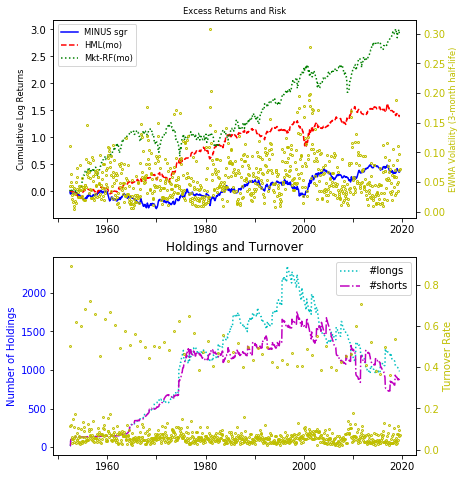

                            OLS Regression Results                            
Dep. Variable:                     sp   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     130.3
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.34e-48
Time:                        15:03:49   Log-Likelihood:                 1693.1
No. Observations:                 681   AIC:                            -3380.
Df Residuals:                     678   BIC:                            -3367.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      2.304      0.0

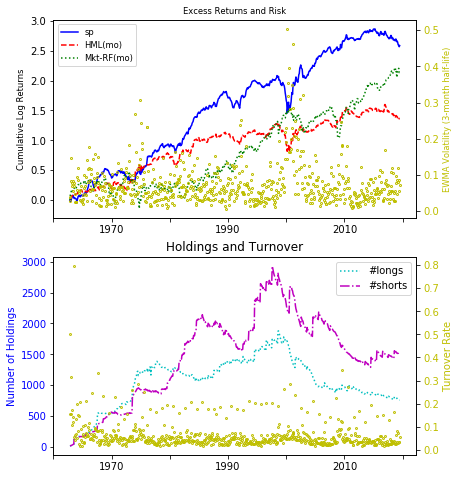

                            OLS Regression Results                            
Dep. Variable:                   tang   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     50.71
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.75e-21
Time:                        15:05:32   Log-Likelihood:                 2229.9
No. Observations:                 818   AIC:                            -4454.
Df Residuals:                     815   BIC:                            -4440.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.001      2.585      0.0

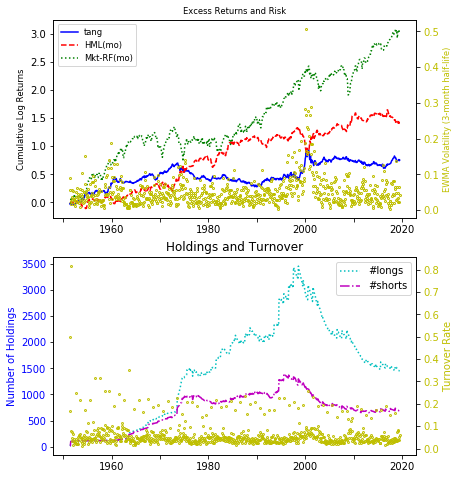

                            OLS Regression Results                            
Dep. Variable:                  bm_ia   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     69.13
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           4.99e-28
Time:                        15:07:05   Log-Likelihood:                 1852.4
No. Observations:                 675   AIC:                            -3699.
Df Residuals:                     672   BIC:                            -3685.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.001      0.365      0.7

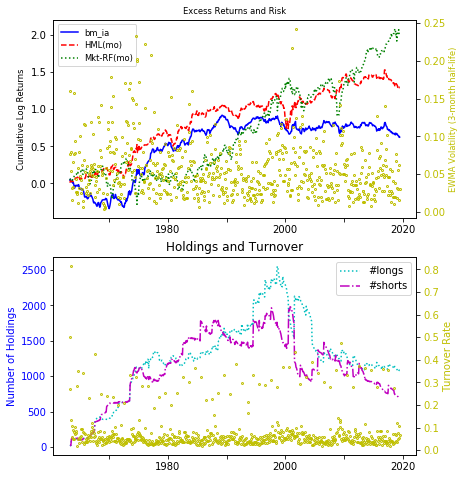

                            OLS Regression Results                            
Dep. Variable:                 cfp_ia   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     4.753
Date:                Sat, 01 Feb 2020   Prob (F-statistic):            0.00892
Time:                        15:08:35   Log-Likelihood:                 1779.0
No. Observations:                 678   AIC:                            -3552.
Df Residuals:                     675   BIC:                            -3539.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.001      3.218      0.0

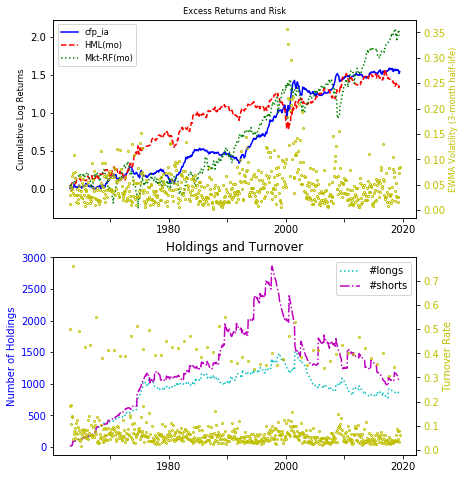

                            OLS Regression Results                            
Dep. Variable:                chatoia   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                    0.7500
Date:                Sat, 01 Feb 2020   Prob (F-statistic):              0.473
Time:                        15:10:07   Log-Likelihood:                 2403.6
No. Observations:                 794   AIC:                            -4801.
Df Residuals:                     791   BIC:                            -4787.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.000      3.962      0.0

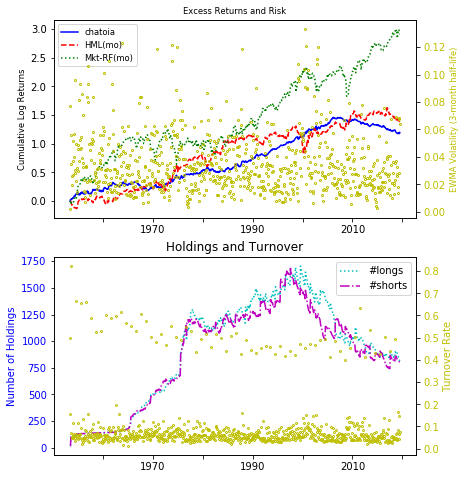

                            OLS Regression Results                            
Dep. Variable:                 chpmia   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     4.235
Date:                Sat, 01 Feb 2020   Prob (F-statistic):             0.0148
Time:                        15:11:24   Log-Likelihood:                 2185.0
No. Observations:                 806   AIC:                            -4364.
Df Residuals:                     803   BIC:                            -4350.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.001      1.744      0.0

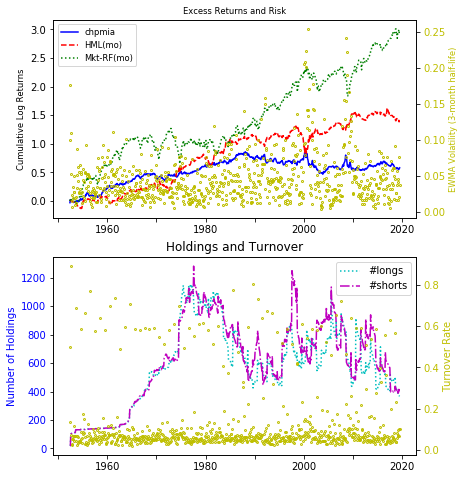

                            OLS Regression Results                            
Dep. Variable:       MINUS pchcapx_ia   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.621
Date:                Sat, 01 Feb 2020   Prob (F-statistic):             0.0272
Time:                        15:12:41   Log-Likelihood:                 2279.2
No. Observations:                 805   AIC:                            -4552.
Df Residuals:                     802   BIC:                            -4538.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      1.635      0.1

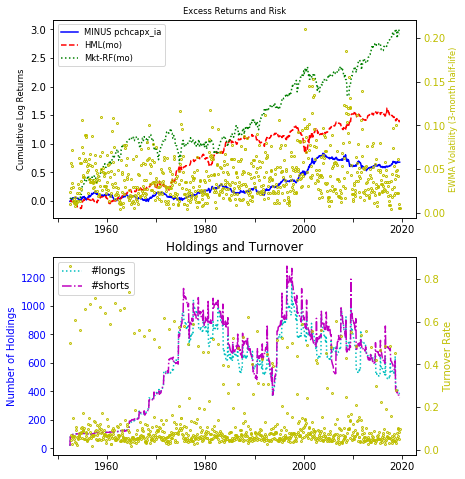

                            OLS Regression Results                            
Dep. Variable:          MINUS chempia   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     17.13
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           5.15e-08
Time:                        15:14:22   Log-Likelihood:                 2431.2
No. Observations:                 818   AIC:                            -4856.
Df Residuals:                     815   BIC:                            -4842.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.249      0.2

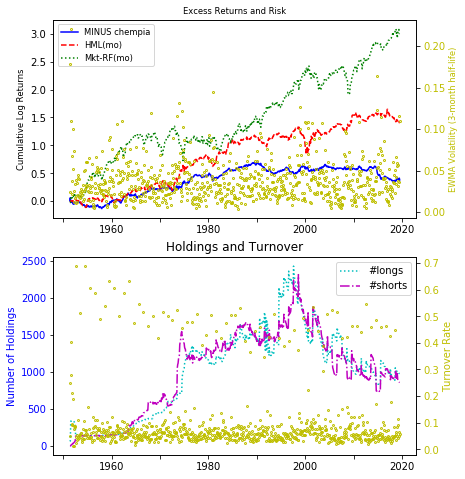

                            OLS Regression Results                            
Dep. Variable:           MINUS mve_ia   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     4.398
Date:                Sat, 01 Feb 2020   Prob (F-statistic):             0.0127
Time:                        15:15:54   Log-Likelihood:                 1354.9
No. Observations:                 681   AIC:                            -2704.
Df Residuals:                     678   BIC:                            -2690.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.001      2.768      0.0

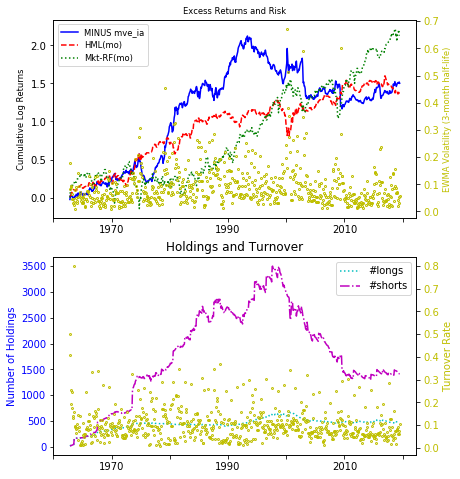

In [7]:
import pandas as pd
def run_backtest(backtest, crsp, signal, window, benchnames, rebalbeg, rebalend, data,
                 outdir = '',  html = 'index.html',  flip=None):
    """wrapper to run pipeline of backtest methods, and (optionally) save to file and .jpg"""
    holdings = crsp.portfolio_sorts(signal, data=data, beg=rebalbeg, end=rebalend, window=window)
    backtest.performance(crsp, holdings, label = signal)
    backtest.save()
    s = backtest.attribution(benchnames, flip=flip)
    backtest.plot(benchnames, savefig = outdir + signal + '.jpg' if outdir else None)
    if html:
        with open(outdir + 'index.html', 'at') as f:
            f.write("<pre>\n")
            f.write(str(s) + "\n\nAnnualized performance and turnover\n")
            f.writelines("\n".join('%-10s:%8.4f' % (k,v) for k,v in backtest.annualized.items()))
            f.write("\n</pre>\n")
            f.write('<img src="{}"><hr><p>\n'.format(signal + '.jpg'))
    else:
        print(s)
        print(pd.Series(backtest.annualized))
        plt.show()
if True:   
    outdir, html = '',''
    rebalbeg, rebalend = 19500101, 20190630
    benchnames = ['HML(mo)', 'Mkt-RF(mo)'] #['Mom']  #['ST_Rev(mo)']   #                                     
    for signal in columns:
        run_backtest(backtest, crsp, signal, 12,  # use latest signal from recent twelve months' rebalances  
                     benchnames, rebalbeg, rebalend, signals, outdir=outdir, html=html)

### comment

### comment

### comment

### comment

### comment

### comment

### comment

### comment

### comment

### comment